In [81]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import random
from torchsummary import summary

# Video

In [34]:
TrDict = {
	"csrt": cv2.legacy.TrackerCSRT_create,
	"kcf": cv2.TrackerKCF_create,
	"boosting": cv2.legacy.TrackerBoosting_create,
	"mil": cv2.TrackerMIL_create,
	"tld": cv2.legacy.TrackerTLD_create,
	"medianflow": cv2.legacy.TrackerMedianFlow_create,
	"mosse": cv2.legacy.TrackerMOSSE_create
    }
multi_trackers = cv2.legacy.MultiTracker_create()

In [95]:
v = cv2.VideoCapture('data\Arsenal_goal.mp4')
multi_trackers = cv2.legacy.MultiTracker_create()
ret, frame = v.read()
frame1 = frame
for i in range(1):
    cv2.imshow("Frame", frame)
    bb_i = cv2.selectROI("Frame", frame)
    tracker_i = TrDict['csrt']()
    multi_trackers.add(tracker_i, frame, bb_i)
    print(bb_i)

(582, 285, 64, 92)


In [52]:
while True:
    ret, frame = v.read()
    if not ret:
        break
    (success, boxes) = multi_trackers.update(frame)
    for box in boxes:
        (x,y,w,h) = [int(a) for a in box]
        cv2.rectangle(frame, (x,y), (x+w,y+h), (100, 255,0), 2)
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(5) & 0xFF
    if key == ord("q"):
        break
v.release()
cv2.destroyAllWindows()

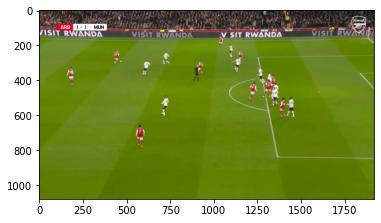

In [54]:
plt.imshow(cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB))

# Model

In [75]:
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [119]:
from torchvision.transforms import transforms as transforms


model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=True)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device(
    'cpu')

model.eval()
model.to(device)


transform = transforms.Compose([
transforms.ToTensor()
])

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [124]:

print(frame1.shape)
image = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
original_image = image.copy()

image = transform(image)
print(image.shape)
image = image.unsqueeze(0).to(device)
print(image.shape)

with torch.no_grad():
    # forward pass of the image through the modle
    outputs = model(image)
    
threshold = 0.5
# get all the scores
scores = list(outputs[0]['scores'].detach().cpu().numpy())
# index of those scores which are above a certain threshold
thresholded_preds_inidices = [scores.index(i) for i in scores if i > threshold]
thresholded_preds_count = len(thresholded_preds_inidices)
# get the masks
masks = (outputs[0]['masks']>0.5).squeeze().detach().cpu().numpy()
# discard masks for objects which are below threshold
masks = masks[:thresholded_preds_count]
# get the bounding boxes, in (x1, y1), (x2, y2) format
boxes = [[(int(i[0]), int(i[1])), (int(i[2]), int(i[3]))]  for i in outputs[0]['boxes'].detach().cpu()]
# discard bounding boxes below threshold value
boxes = boxes[:thresholded_preds_count]
# get the classes labels
labels = [class_names[i] for i in outputs[0]['labels']]

cnnBoxes = boxes

(1080, 1920, 3)
torch.Size([3, 1080, 1920])
torch.Size([1, 3, 1080, 1920])


[(554, 654), (605, 788)]


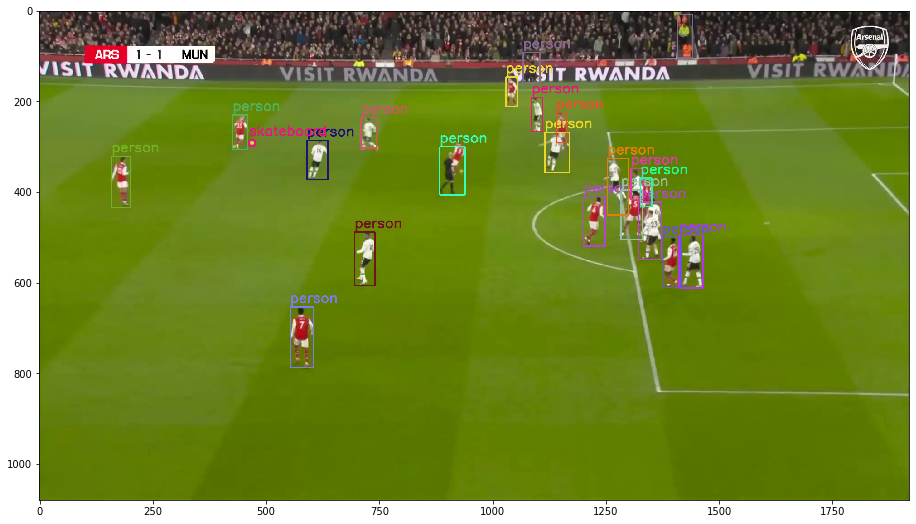

In [125]:
COLORS = np.random.uniform(0, 255, size=(len(class_names), 3))

def draw_segmentation_map(image, masks, boxes, labels):
    alpha = 1 
    beta = 0.6 # transparency for the segmentation map
    gamma = 0 # scalar added to each sum
    for i in range(len(masks)):
        red_map = np.zeros_like(masks[i]).astype(np.uint8)
        green_map = np.zeros_like(masks[i]).astype(np.uint8)
        blue_map = np.zeros_like(masks[i]).astype(np.uint8)
        # apply a randon color mask to each object
        color = COLORS[random.randrange(0, len(COLORS))]
        red_map[masks[i] == 1], green_map[masks[i] == 1], blue_map[masks[i] == 1]  = color
        # combine all the masks into a single image
        segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
        #convert the original PIL image into NumPy format
        image = np.array(image)
        # convert from RGN to OpenCV BGR format
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        # apply mask on the image
        #cv2.addWeighted(image, alpha, segmentation_map, beta, gamma, image)
        # draw the bounding boxes around the objects
        cv2.rectangle(image, boxes[i][0], boxes[i][1], color=color, 
                      thickness=2)
        # put the label text above the objects
        cv2.putText(image , labels[i], (boxes[i][0][0], boxes[i][0][1]-10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, color, 
                    thickness=2, lineType=cv2.LINE_AA)
    
    return image

result = draw_segmentation_map(original_image, masks, cnnBoxes, labels)
plt.figure(figsize = (16,9))
plt.imshow(result, interpolation='nearest')

print(boxes[0])

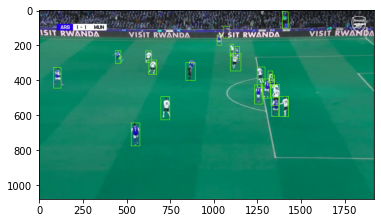

In [114]:
def convertBoxes(cnnBoxes):
    newBoxes = []
    for bb in cnnBoxes:
        h = bb[1][0] - bb[0][0]
        w = bb[1][1] - bb[0][1]
        x = bb[0][0]
        y = bb[0][1]
        newBoxes.append((x,y,h,w))
    return newBoxes

def makeTrackers(cnnBoxes):
    multi_trackers = cv2.legacy.MultiTracker_create()
    boxes = convertBoxes(cnnBoxes)

    for bb_i in boxes:
        tracker_i = TrDict['csrt']()
        multi_trackers.add(tracker_i, frame, bb_i)

    return multi_trackers


v = cv2.VideoCapture('data\Arsenal_goal.mp4')
ret, frame = v.read()
frame1 = frame
multi_trackers = makeTrackers(cnnBoxes)

while True:
    ret, frame = v.read()
    if not ret:
        break
    (success, boxes) = multi_trackers.update(frame)
    for box in boxes:
        (x,y,w,h) = [int(a) for a in box]
        cv2.rectangle(frame, (x,y), (x+w,y+h), (100, 255,0), 2)
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(5) & 0xFF
    if key == ord("q"):
        break
v.release()
cv2.destroyAllWindows()